# Introduction

Heart disease is an often-lethal condition, and being able to accurately predict if patients have it, based on easy-to-observe qualities, would allow for quicker action from doctors and better patient outcomes. So here we ask the question: is it possible to predict whether a patient has heart disease based on a set of measurable factors? To build a model that could answer this, we used the publicly-available heart disease dataset donated by the Hungarian Institute of Cardiology, the University Hospitals of Zurich and Basel, the V. A. Medical Center of Long Beach, and the Cleveland Clinic Foundation. Each row in this dataset represents a patient, and the columns store physical, health-related information about each patient — such as their age, sex, type of chest pain, and resting blood pressure. There are 14 variables in total. The column we are attempting to predict has values of either “true” or “false”, indicating whether a patient has some variety of heart disease. The dataset contains four databases, each with around 100 to 300 patients, donated by institutions in Switzerland, Hungary, and two locations in America. We trained and tested our model on data from all of the databases, as this gives us a larger sample size, and an additional variable to work with (region). This brings the total number of columns in our dataset to 15.

# Preliminary Exploratory Data Analysis

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [2]:



cleveland_data<- read_delim("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data",
                         col_name = FALSE)
colnames(cleveland_data)<- c("age","sex","cp","trestbps","chol","fbs","restecg","thalach","exang","oldpeak","slope","ca","thal","num")
cleveland_data<- mutate(cleveland_data, region="Cleveland")
cleveland_data$num<-ifelse(cleveland_data$num==0,"true","false")


cleveland_data               






hungarian_data<-read_delim("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.hungarian.data",
                          col_name = FALSE)
colnames(hungarian_data)<- c("age","sex","cp","trestbps","chol","fbs","restecg","thalach","exang","oldpeak","slope","ca","thal","num")
hungarian_data<- mutate(hungarian_data, region="Hungarian")
hungarian_data$num<-ifelse(hungarian_data$num==0,"true","false")


switzerland_data<-read_delim("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.switzerland.data",
                            col_name = FALSE)
colnames(switzerland_data)<-c("age","sex","cp","trestbps","chol","fbs","restecg","thalach","exang","oldpeak","slope","ca","thal","num")
switzerland_data<- mutate(switzerland_data, region="Switzerland")
switzerland_data$num<-ifelse(switzerland_data$num==0,"true","false")



va_data<-read_delim("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.va.data",
                   col_name = FALSE)
colnames(va_data)<-c("age","sex","cp","trestbps","chol","fbs","restecg","thalach","exang","oldpeak","slope","ca","thal","num")
va_data<- mutate(va_data, region="VA_Long_Beach")
va_data$num<-ifelse(va_data$num==0,"true","false")


heart_disease_data<-rbind(cleveland_data,hungarian_data,switzerland_data,va_data)
heart_disease_data <- heart_disease_data |> filter(trestbps != 0) #Having 0 blood pressure is impossible, this outlier is filtered out

heart_disease_data

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): X12, X13
dbl (12): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,region
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,true,Cleveland
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,false,Cleveland
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,false,Cleveland
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0,false,Cleveland
57,0,2,130,236,0,2,174,0,0.0,2,1.0,3.0,false,Cleveland
38,1,3,138,175,0,0,173,0,0.0,1,?,3.0,true,Cleveland


Rows: 294 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (9): X4, X5, X6, X7, X8, X9, X11, X12, X13
dbl (5): X1, X2, X3, X10, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 123 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (9): X4, X6, X7, X8, X9, X10, X11, X12, X13
dbl (5): X1, X2, X3, X5, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 200 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (9): X4, X5, X6, X8, X9, X10, X11, X12, X13
dbl (5): X1, X2, X3, X7, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or se

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,region
<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,true,Cleveland
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,false,Cleveland
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,false,Cleveland
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
55,1,4,122,223,1,1,100,0,0,?,?,6,false,VA_Long_Beach
58,1,4,?,385,1,2,?,?,?,?,?,?,true,VA_Long_Beach
62,1,2,120,254,0,2,93,1,0,?,?,?,false,VA_Long_Beach


In [3]:
heart_disease_split <- initial_split(heart_disease_data, prop = 0.75, strata = num)
heart_disease_train <- training(heart_disease_split)
heart_disease_test <- testing(heart_disease_split)

heart_disease_train

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,region
<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,false,Cleveland
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,false,Cleveland
62,0,4,140,268,0,2,160,0,3.6,3,2.0,3.0,false,Cleveland
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
51,0,4,114,258,1,2,96,0,1,1,?,?,true,VA_Long_Beach
62,1,1,?,139,0,1,?,?,?,?,?,?,true,VA_Long_Beach
58,1,4,?,385,1,2,?,?,?,?,?,?,true,VA_Long_Beach


In [4]:


tidy_heart_disease_data<- heart_disease_train|>
                          select(region,sex,cp,thalach,trestbps,num)|>
                          filter(cp!="?",sex!="?",thalach!="?",trestbps!="?")|>
                          mutate(region=as.factor(region),
                                 sex=as.numeric(sex),
                                 cp=as.numeric(cp),
                                 thalach=as.numeric(thalach),
                                 trestbps=as.numeric(trestbps),
                                 num = as.factor(num))
tidy_heart_disease_data

data_miss_num<-tidy_heart_disease_data|>
map_df(is.na)|>
map_df(sum)
data_miss_num
data_obs_num<-tidy_heart_disease_data|>
summarize(n_cp=sum(!is.na(cp)),
          n_region=sum(!is.na(region)),
          n_sex=sum(!is.na(sex)),
          n_thalach=sum(!is.na(thalach)),
          n_trestbps=sum(!is.na(trestbps)))
data_obs_num

heart_rate_mean<-tidy_heart_disease_data|>
            summarize(mean.rate=mean(thalach, na.rm=TRUE))
heart_rate_mean

blood_pressure_mean<-tidy_heart_disease_data|>
            summarize(mean.pressure=mean(trestbps, na.rm=TRUE))
blood_pressure_mean



region,sex,cp,thalach,trestbps,num
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
Cleveland,1,4,108,160,false
Cleveland,1,4,129,120,false
Cleveland,0,4,160,140,false
⋮,⋮,⋮,⋮,⋮,⋮
VA_Long_Beach,1,4,96,130,true
VA_Long_Beach,1,3,151,134,true
VA_Long_Beach,0,4,96,114,true


region,sex,cp,thalach,trestbps,num
<int>,<int>,<int>,<int>,<int>,<int>
0,0,0,0,0,0


n_cp,n_region,n_sex,n_thalach,n_trestbps
<int>,<int>,<int>,<int>,<int>
641,641,641,641,641


mean.rate
<dbl>
137.1357


mean.pressure
<dbl>
132.4696


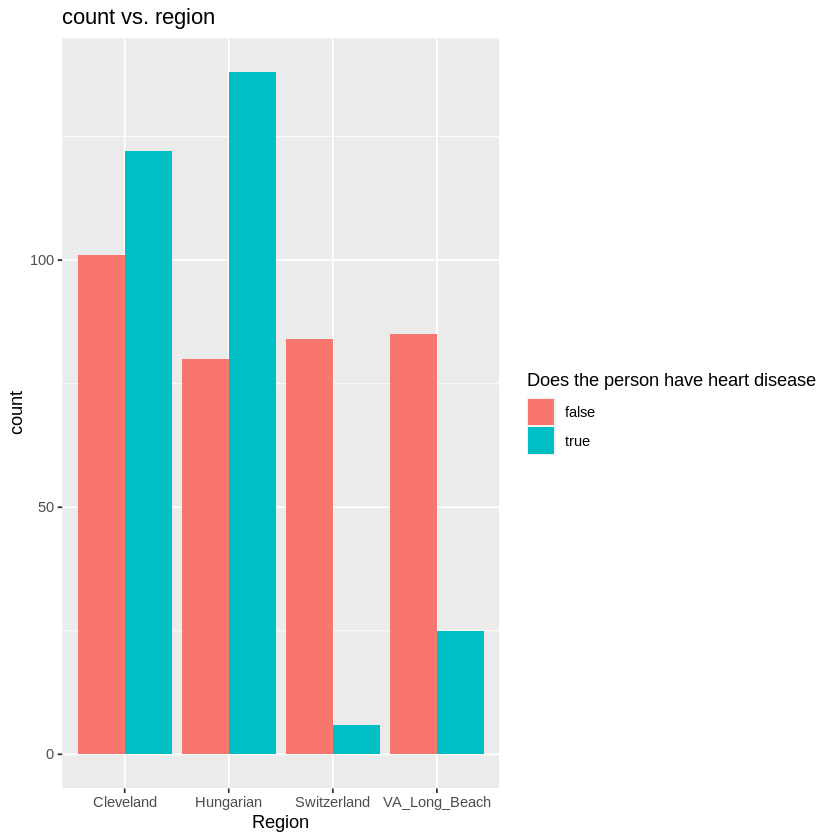

In [5]:
region_plot<- tidy_heart_disease_data|>
                 ggplot(aes(x = region, fill = num)) + 
    geom_bar(position = 'dodge') + 
    xlab("Region") +
    ylab("count") +
    labs(fill = "Does the person have heart disease") +
    ggtitle("count vs. region")


region_plot

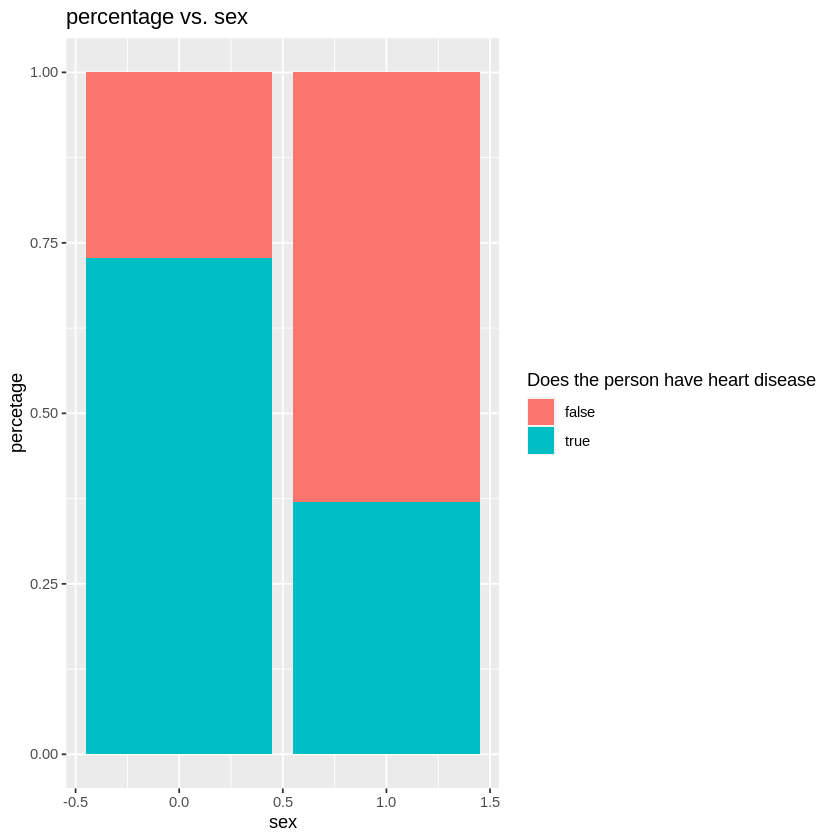

In [6]:

sex_plot<- tidy_heart_disease_data|>
                 ggplot(aes(x = sex, fill = num)) + 
    geom_bar(position = 'fill') + 
    xlab("sex") +
    ylab("percetage") +
    labs(fill = "Does the person have heart disease") +
    ggtitle("percentage vs. sex")


sex_plot

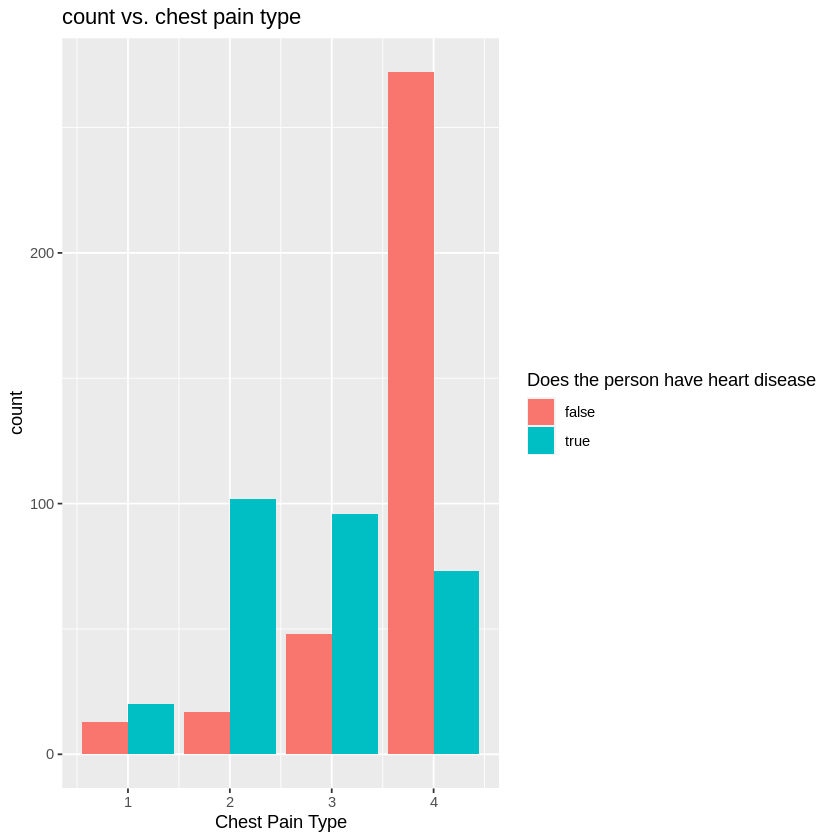

In [7]:

chest_pain_plot<- tidy_heart_disease_data|>
                 ggplot(aes(x = cp, fill = num)) + 
    geom_bar(position = 'dodge') + 
    xlab("Chest Pain Type") +
    ylab("count") +
    labs(fill = "Does the person have heart disease") +
    ggtitle("count vs. chest pain type")


chest_pain_plot

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,region
<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,true,Cleveland
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,false,Cleveland
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,false,Cleveland
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
55,1,4,122,223,1,1,100,0,0,?,?,6,false,VA_Long_Beach
58,1,4,?,385,1,2,?,?,?,?,?,?,true,VA_Long_Beach
62,1,2,120,254,0,2,93,1,0,?,?,?,false,VA_Long_Beach


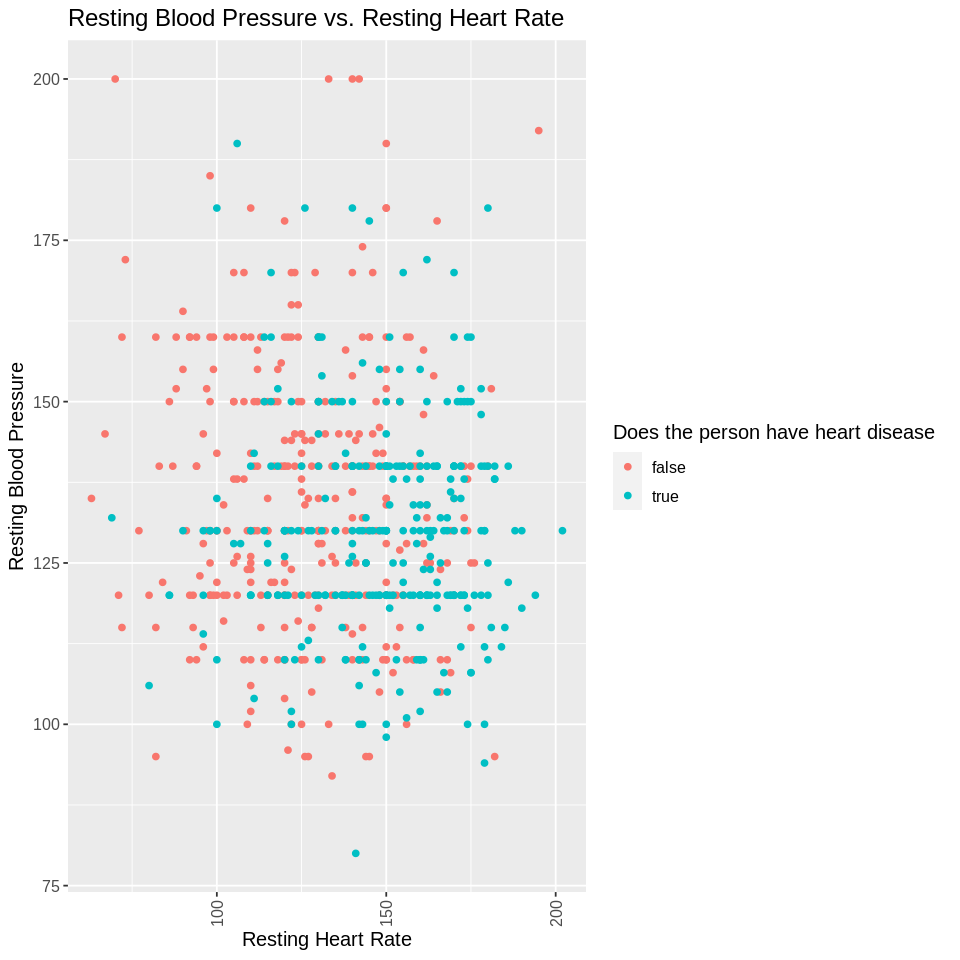

In [8]:
options(repr.plot.width = 8, repr.plot.height = 8)

rate_pressure_plot<- tidy_heart_disease_data|>
                 ggplot(aes(x = thalach,y=trestbps, color=num)) + 
    geom_point() + 
    xlab("Resting Heart Rate") +
    ylab("Resting Blood Pressure") +
    labs(color = "Does the person have heart disease") +
    theme(text = element_text(size = 12), axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1)) +
    ggtitle("Resting Blood Pressure vs. Resting Heart Rate")


rate_pressure_plot

heart_disease_data

# Methods



# Expected Outcomes And Significance